In [1]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

# set the CARMA model parameters
sigmay = 2.3  # dispersion in the time series
p = 5  # order of the AR polynomial
mu = 17.0  # mean of the time series
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])  # widths of of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0])  # centroids of Lorentzian components
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent) # compute the roots r_k from the Lorentzian function parameters
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# convert CARMA model variance to variance in the driving white noise
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)  # carma_vari

Text(0,0.5,'Power Spectrum [variance / frequency]')

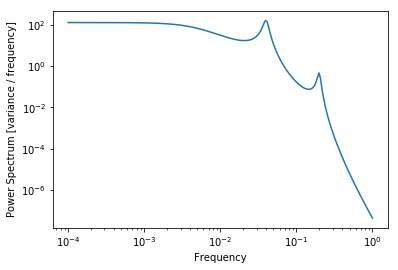

In [2]:
frequencies = np.logspace(-4.0, 0.0, 200)
pspec = cm.power_spectrum(frequencies, np.sqrt(sigsqr), ar_coefs, ma_coefs)
plt.loglog(frequencies, pspec)
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum [variance / frequency]')

Text(0,0.5,'Autocorrelation Function')

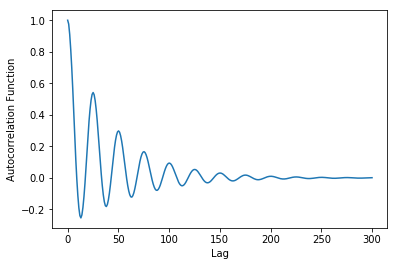

In [3]:


lag = np.linspace(0.0, 300.0, 300)
autocovar = cm.carma_variance(sigsqr, ar_roots, ma_coefs, lag)
autocorr = autocovar / autocovar[0]  # normalize by stationary variance
plt.plot(lag, autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Function')



(0, 902.6925199219819)

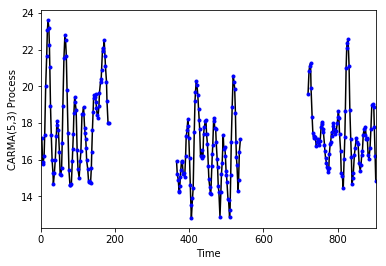

In [4]:
ny = 270
t = np.zeros(ny)
dt = np.random.uniform(1.0, 3.0, ny)
t[0:90] = np.cumsum(dt[0:90])  # season 1
t[90:2*90] = 180 + t[90-1] + np.cumsum(dt[90:2*90])  # season 2, 180 time units between seasons
t[2*90:] = 180 + t[2*90-1] + np.cumsum(dt[2*90:])  # season 3
y = mu + cm.carma_process(t, sigsqr, ar_roots, ma_coefs=ma_coefs)
for i in range(3):
    plt.plot(t[90*i:90*(i+1)], y[90*i:90*(i+1)], 'k')
    plt.plot(t[90*i:90*(i+1)], y[90*i:90*(i+1)], 'b.')
plt.xlabel('Time')
plt.ylabel('CARMA(5,3) Process')
plt.xlim(0, t.max())

Text(0,0.5,'magnitude')

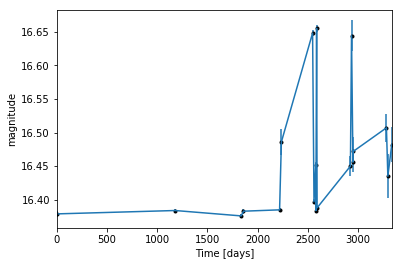

In [6]:
data = np.genfromtxt('LC_G_15818.dat')
juldate = data[:,0]  # time is given by the julian date
t = juldate - juldate.min()  # set first time value to zero for convenience. units of t are days.
y = data[:,1]  # i-band magnitudes
yerr = data[:,2]  # standard deviation in the measurement noise

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')

In [7]:
model = cm.CarmaModel(t, y, yerr, p=6, q=0)

In [8]:
%%capture capt
sample = model.run_mcmc(20000)